# US Adult Census Data relating Income to Social Factors such as Age, Education, race etc.

## Rihad Variawa
### 27-02-2019

The Us Adult income dataset was extracted by Barry Becker from the 1994 US Census Database. The data set consists of anonymous information such as occupation, age, native country, race, capital gain, capital loss, education, work class and more. Each row is labelled as either having a salary greater than ">50K" or "<=50K".

The goal here is to train a binary classifier on the training dataset to predict the column income_bracket which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.

Note that the dataset is made up of **categorical and continuous features.** It also contains missing values The **categorical columns are: workclass, education, marital_status, occupation, relationship, race, gender, native_country**

The continuous columns are: age, education_num, capital_gain, capital_loss, hours_per_week

This Dataset was obtained from the UCI repository, it can be found on [link](http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/)

USAGE This dataset is well suited to developing and testing wide linear classifiers, deep neutral network classifiers and a combination of both. For more info on Combined Deep and Wide Model classifiers, refer to the [Research Paper by Google](https://arxiv.org/abs/1606.07792)

Refer to this kernel for sample usage : https://www.kaggle.com/johnolafenwa/wage-prediction


##Loading Packages

In [0]:
# access kaggle datasets
!pip install kaggle

In [0]:
# for data manipulation
import pandas as pd 
import numpy as np 

from sklearn.metrics import accuracy_score
import re

##Import Dataset

In [0]:
from google.colab import files
uploaded = files.upload()

Saving us-census-data.zip to us-census-data (1).zip


In [0]:
!ls

 adult-test.csv       sample_data	        us-census-data.zip
 adult-training.csv  'us-census-data (1).zip'


In [0]:
!unzip us-census-data.zip

Archive:  us-census-data.zip
replace adult-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace adult-training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
train = pd.read_csv('adult-training.csv', names = columns)
test = pd.read_csv('adult-test.csv', names = columns)

columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

## Exploratory Data Analysis

In [0]:
# to see features
train.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# defining function for estimating missing values in each columns
def missing_value(df):
    miss = []
    col_list = df.columns
    for i in col_list:
        missing = df[i].isnull().sum()
        miss.append(missing)
        list_of_missing = pd.DataFrame(list(zip(col_list,miss)))
    return list_of_missing

In [0]:
missing_value(test)
missing_value(train)

,0,1
0,Age,0
1,Workclass,0
2,fnlgwt,0
3,Education,0
4,Education Num,0
5,Marital Status,0
6,Occupation,0
7,Relationship,0
8,Race,0
9,Sex,0


In [0]:
# categorical feature
train['Relationship'].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: Relationship, dtype: int64

In [0]:
# categorical feature
test['Occupation'].value_counts()

 Prof-specialty       2032
 Exec-managerial      2020
 Craft-repair         2013
 Sales                1854
 Adm-clerical         1841
 Other-service        1628
 Machine-op-inspct    1020
 ?                     966
 Transport-moving      758
 Handlers-cleaners     702
 Tech-support          518
 Farming-fishing       496
 Protective-serv       334
 Priv-house-serv        93
 Armed-Forces            6
Name: Occupation, dtype: int64

### Data Cleaning

In [0]:
train.head()

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# deleted the firt rows of the both dataframes since these are errorneous
train.drop(train.index[0]).head()
test.drop(test.index[0]).head()

print(train.shape)
print(test.shape)

(32561, 15)
(16282, 15)


In [0]:
# a swiss knife tool for separating string columns to separate list and numerical to separate list
all_data = [train, test]
str_list = []

for data in all_data:
    for colname, colvalue in data.iteritems(): 
        if type(colvalue[1]) == str:
            str_list.append(colname) 
num_list = data.columns.difference(str_list)

In [0]:
# no null values its good
print(test.isnull().sum())

Age                0
Workclass          1
fnlgwt             1
Education          1
Education Num      1
Marital Status     1
Occupation         1
Relationship       1
Race               1
Sex                1
Capital Gain       1
Capital Loss       1
Hours/Week         1
Country            1
Above/Below 50K    1
dtype: int64


Looking at the unique values for the categorical columns, it seems there are is special charatcers ' ?'
inserted in the dataframe in place of null values we have to remove it and replace it wiyh nan and deleting the rows with Nan values..
Picture is now clear. As you can see missing values in the WorkClass and Occupation are quite high. We will delete the missing value. 

In [0]:
# the code will replace the special character to nan
for data in all_data:
    for i in data.columns:
        data[i].replace(' ?', np.nan, inplace = True)
    data.dropna(inplace = True)

In [0]:
test.isnull().sum()

Age                0
Workclass          0
fnlgwt             0
Education          0
Education Num      0
Marital Status     0
Occupation         0
Relationship       0
Race               0
Sex                0
Capital Gain       0
Capital Loss       0
Hours/Week         0
Country            0
Above/Below 50K    0
dtype: int64

### Feature Engineering

Creating the target variable

In [0]:
# defining the target variable
for data in all_data:
    data['target'] = data['Above/Below 50K'].apply(lambda x: x.replace('.', ''))
    data['target'] = data['target'].apply(lambda x: x.strip())
    data['target'] = data['target'].apply(lambda x: 1 if x == '>50K' else 0)
    data.drop(['Above/Below 50K'], axis = 1, inplace = True)

In [0]:
train.target.sum()/len(train)

0.24892248524633645

Education and number of work hour/week looks to be a great variables deciding income. Lets create categories to further enhance its effect. We will create low, medium and high education. I will derive a generic function for creating bins

In [0]:
# data can be train or test
# var name is variable name: should be passed as strings within ('')
# bins is list of numeric values like [0,6,10,11]
# group names is list of groups you want to create in list form
def bin_var(data, var, bins, group_names):
    bin_value = bins
    group = group_names
    data[var + 'Cat'] = pd.cut(train[var], bin_value, labels = group)

Education can be divided into three groups 0-6 low and 7-11 medium and above that high 

In [0]:
bin_var(train, 'Education Num', [0,6,11,16], ['Low', 'Medium', 'High'])
bin_var(test, 'Education Num', [0,6,11,16], ['Low', 'Medium', 'High'])

In [0]:
pd.crosstab(train['Education NumCat'], train['target'])

target,0,1
Education NumCat,,
Low,2179,137
Medium,15865,3385
High,4610,3986


The same way we can bin the Hours/Week variable. Initial exploation suggest that 40 hours is the most fequent value which make sense that it is 8hr/day. Hence we will bin this variable around this value. 

In [0]:
bin_var(train, 'Hours/Week', [0,35,40,60,100], ['Low', 'Medium', 'High','VeryHigh'])
bin_var(test, 'Hours/Week', [0,35,40,60,100], ['Low', 'Medium', 'High','VeryHigh'])

In [0]:
pd.crosstab(train['Hours/WeekCat'], train['target'], margins = True)

target,0,1,All
Hours/WeekCat,,,
Low,5369,505,5874
Medium,11829,3262,15091
High,4796,3349,8145
VeryHigh,660,392,1052
All,22654,7508,30162


Classifying the occupation into Highly Skilled and low Skilled

In [0]:
occu = pd.crosstab(train['Occupation'], train['target'], margins = True).reset_index()

In [0]:
def occup(x):
    if re.search('managerial', x):
        return 'Highskill'
    elif re.search('specialty',x):
        return 'Highskill'
    else:
        return 'Lowskill'

In [0]:
train['Occupa_cat'] = train.Occupation.apply(lambda x: x.strip()).apply(lambda x: occup(x))
test['Occupa_cat'] = test.Occupation.apply(lambda x: x.strip()).apply(lambda x: occup(x))

In [0]:
train['Occupa_cat'].value_counts()

Lowskill     22132
Highskill     8030
Name: Occupa_cat, dtype: int64

Same way we can bin the Age variable. The minimum age in train is 17 and max is 90. We can categorize them as young, middle_aged and old

In [0]:
bin_var(test, 'Age', [17,30,55,100], ['Young', 'Middle_aged', 'Old'])

In [0]:
bin_var(train, 'Age', [17,30,55,100], ['Young', 'Middle_aged', 'Old'])

Marital status can also be binned

In [0]:
train['Marital Status_cat']=train['Marital Status'].apply(lambda x: 'married' if x.startswith('Married',1) else 'Single')
test['Marital Status_cat']=test['Marital Status'].apply(lambda x: 'married' if x.startswith('Married',1) else 'Single')

Race has been binned into White and others

In [0]:
pd.crosstab(train['Race'], train['target'], margins = True)

target,0,1,All
Race,,,
Amer-Indian-Eskimo,252,34,286
Asian-Pac-Islander,647,248,895
Black,2451,366,2817
Other,210,21,231
White,19094,6839,25933
All,22654,7508,30162


In [0]:
train['Race_cat'] = train['Race'].apply(lambda x: x.strip())
train['Race_cat'] = train['Race_cat'].apply(lambda x: 'White' if x == 'White' else 'Other')
test['Race_cat'] = test['Race'].apply(lambda x: x.strip())
test['Race_cat'] = test['Race_cat'].apply(lambda x: 'White' if x == 'White' else 'Other')

Work Class is divided into three categories Private, Selfemployed, gov and others

In [0]:
train['Workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: Workclass, dtype: int64

In [0]:
def workclas(x):
    if re.search('Private', x):
        return 'Private'
    elif re.search('Self', x):
        return 'selfempl'
    elif re.search('gov', x):
        return 'gov'
    else:
        return 'others'

In [0]:
train['WorfClass_cat'] = train.Workclass.apply(lambda x: x.strip()).apply(lambda x: workclas(x))
test['WorfClass_cat'] = test.Workclass.apply(lambda x: x.strip()).apply(lambda x: workclas(x))

In [0]:
train['WorfClass_cat'].value_counts()

Private     22286
gov          4289
selfempl     3573
others         14
Name: WorfClass_cat, dtype: int64

* Assigning the targte to Y variable

In [0]:
# assigning the target to Y variable
Y_tr = train['target']
Y_te = test['target']

In [0]:
# since target is already assigned I Will drop the target from the train and test along with other unnecessary variables
train.drop(['Education','Occupation','Race','Education Num','Age', 'Hours/Week', 'Marital Status','target','fnlgwt','Workclass', 'Capital Gain','Capital Loss', 'Country'], axis = 1, inplace = True)
test.drop(['Education','Occupation','Race','Education Num','Age', 'Hours/Week', 'Marital Status','Workclass','target','fnlgwt', 'Capital Gain','Capital Loss', 'Country'], axis = 1, inplace = True)

I will now create dummies for the categorical variables

In [0]:
str_list = ['WorfClass_cat','Education NumCat', 'AgeCat', 'Race_cat',
            'Hours/WeekCat',
            'Marital Status_cat',
            'Occupa_cat',
            'Relationship',
            
            'Sex']

train_set = pd.get_dummies(train, columns=str_list)
test_set = pd.get_dummies(test, columns=str_list)


### Feature Selection Using Variance Threshold

Variance Threshold is a univariate  approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by
The below approach removes variable which have more than 80% values are either 0 or 1

In [0]:
train_set.columns

Index(['WorfClass_cat_Private', 'WorfClass_cat_gov', 'WorfClass_cat_others',
       'WorfClass_cat_selfempl', 'Education NumCat_Low',
       'Education NumCat_Medium', 'Education NumCat_High', 'AgeCat_Young',
       'AgeCat_Middle_aged', 'AgeCat_Old', 'Race_cat_Other', 'Race_cat_White',
       'Hours/WeekCat_Low', 'Hours/WeekCat_Medium', 'Hours/WeekCat_High',
       'Hours/WeekCat_VeryHigh', 'Marital Status_cat_Single',
       'Marital Status_cat_married', 'Occupa_cat_Highskill',
       'Occupa_cat_Lowskill', 'Relationship_ Husband',
       'Relationship_ Not-in-family', 'Relationship_ Other-relative',
       'Relationship_ Own-child', 'Relationship_ Unmarried',
       'Relationship_ Wife', 'Sex_ Female', 'Sex_ Male'],
      dtype='object')

In [0]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_select(df, thresh = 0.0, na_replacement = -999):
    
    # Make a deep copy of the dataframe
    df1 = df.copy(deep = True)
    
    # passing Threshold
    selector = VarianceThreshold(thresh)
    
    # fill NA values as VarianceThreshold cannot deal with those
    selector.fit(df1.fillna(na_replacement))
    
    # get new df with columns deleted that have NA values
    df2 = df.loc[:,selector.get_support(indices = False)] 
    return df2

In [0]:
df2 = variance_threshold_select(train_set, thresh = .8* (1 - .8))

In [0]:
print(df2.columns)

Index(['WorfClass_cat_Private', 'Education NumCat_Medium',
       'Education NumCat_High', 'AgeCat_Young', 'AgeCat_Middle_aged',
       'Hours/WeekCat_Medium', 'Hours/WeekCat_High',
       'Marital Status_cat_Single', 'Marital Status_cat_married',
       'Occupa_cat_Highskill', 'Occupa_cat_Lowskill', 'Relationship_ Husband',
       'Relationship_ Not-in-family', 'Sex_ Female', 'Sex_ Male'],
      dtype='object')


As you can see below the number of columns have been reduced to 15 because of the the variance threshold. The removed columns have the same value in 80% of the observations

In [0]:
# creates list of columns
col_tr = df2.columns

# creates list of columns for test
col_te = test_set.columns 

# creates array of values of features
X_tr=df2.values 

# subseting the test dataset to get the same variable as train and
X_te = test_set[col_tr].values

In [0]:
len(col_tr)

15

### Modelling Process

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


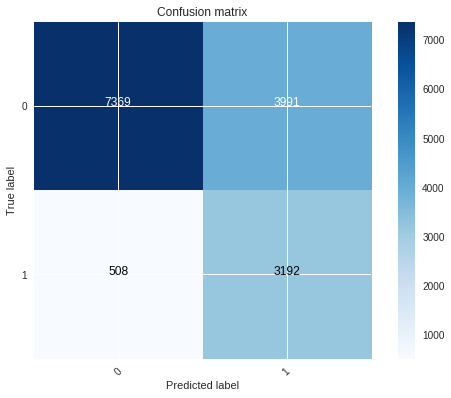

Precision =     0.444
Recall (TPR) =  0.863
Fallout (FPR) = 3.513e-01


In [0]:
lrn = LogisticRegression(penalty = 'l1', C = .001, class_weight = 'balanced')

lrn.fit(X_tr, Y_tr)
y_pred = lrn.predict(X_te)
cm = confusion_matrix(Y_te, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1)

In [0]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
    
print('Accuracy:', accuracy_score(Y_te, y_pred))
print('F1 score:', f1_score(Y_te,y_pred))

Accuracy: 0.701261620185923
F1 score: 0.5866029587429936


I achieved the accuracy of 72% with recall of 74% on test which is quite good.

### Understanding Important features for High and Low Paying Jobs

In [0]:
# understanding the coefficients
coff = pd.DataFrame(lrn.coef_).T 
col = pd.DataFrame(col_tr).T 

print(coff)
print(col)

           0
0   0.000000
1   0.000000
2   0.560629
3  -0.275564
4   0.001234
5   0.000000
6   0.078825
7  -0.934614
8   0.582120
9   0.069669
10 -0.295364
11  0.000000
12  0.000000
13  0.000000
14  0.000000
                      0                        1                      2   \
0  WorfClass_cat_Private  Education NumCat_Medium  Education NumCat_High   

             3                   4                     5                   6   \
0  AgeCat_Young  AgeCat_Middle_aged  Hours/WeekCat_Medium  Hours/WeekCat_High   

                          7                           8   \
0  Marital Status_cat_Single  Marital Status_cat_married   

                     9                    10                     11  \
0  Occupa_cat_Highskill  Occupa_cat_Lowskill  Relationship_ Husband   

                            12           13         14  
0  Relationship_ Not-in-family  Sex_ Female  Sex_ Male  


As you can see above positive coefficients are for high paying and neagtive for low paying.As you can see High number of years of education, high workhour/week are importand for getting high salary and vice versa

In [0]:
from sklearn.feature_selection import RFE, f_regression

# stop the search when only the last feature is left
rfe = RFE(lrn, n_features_to_select=10, verbose = 3)
rfe.fit(X_tr,Y_tr)
list(zip(map(lambda x: round(x, 4), rfe.ranking_), col_tr))

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 12 features.
Fitting estimator with 11 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[(6, 'WorfClass_cat_Private'),
 (5, 'Education NumCat_Medium'),
 (1, 'Education NumCat_High'),
 (1, 'AgeCat_Young'),
 (1, 'AgeCat_Middle_aged'),
 (4, 'Hours/WeekCat_Medium'),
 (1, 'Hours/WeekCat_High'),
 (1, 'Marital Status_cat_Single'),
 (1, 'Marital Status_cat_married'),
 (1, 'Occupa_cat_Highskill'),
 (1, 'Occupa_cat_Lowskill'),
 (3, 'Relationship_ Husband'),
 (2, 'Relationship_ Not-in-family'),
 (1, 'Sex_ Female'),
 (1, 'Sex_ Male')]